# This notebook contains the code for Shapley values for the Canadian Dataset for Task 2

#  Project Setup

In [2]:
!pip install lightgbm
!pip install coral_pytorch
!pip install catboost
!pip install deslib
!pip install shap
!pip install hyperopt
!pip install git+https://github.com/hyperopt/hyperopt-sklearn
!wget  https://anaconda.org/pytorch/faiss-cpu/1.2.1/download/linux-64/faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!tar xvjf faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
!pip install mkl
!apt install libomp-dev
!pip install faiss

# !pip install rgf_python
# !pip install --ignore-installed --upgrade tensorflow==2.4.1
# !pip install --force-reinstall --no-deps git+https://github.com/ck37/coral-ordinal/
# !pip install pygam
# !apt install libomp-dev
# !pip install faiss-gpu

     |████████████████████████████████| 76.1 MB 48 kB/s 
     |████████████████████████████████| 158 kB 11.5 MB/s 
  Cloning https://github.com/hyperopt/hyperopt-sklearn to /tmp/pip-req-build-37eew5ma
  Running command git clone -q https://github.com/hyperopt/hyperopt-sklearn /tmp/pip-req-build-37eew5ma
     |████████████████████████████████| 154 kB 11.6 MB/s 
  Created wheel for hpsklearn: filename=hpsklearn-0.0.3-py3-none-any.whl size=27011 sha256=7ce4c24fcf4d9f643333c484cdd4a1ad5b699bdc8d3b39e4fc51ad0f67e81bc5
  Stored in directory: /tmp/pip-ephem-wheel-cache-fxgcagcx/wheels/4b/06/53/c35e360ca94aa0ab93518bf53abe5fb270c95dbe56b8e2e76b
Successfully built hpsklearn
--2022-03-20 02:57:22--  https://anaconda.org/pytorch/faiss-cpu/1.2.1/download/linux-64/faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.92.24, 104.17.93.24, 2606:4700::6811:5d18, ...
Connecting to anaconda.org (anaconda.org)|104.17.92.24|:443... connected.
HTTP request sent, awaitin

In [3]:
import pandas as pd
import shap
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from numpy import mean
from numpy import std
from numpy import arange
from numpy import save

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from scipy.stats import kendalltau
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

from hpsklearn import HyperoptEstimator
import faiss

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from deslib.dcs import OLA
from deslib.dcs import MCB
from deslib.des import DESP
from deslib.des import KNORAE
from deslib.des import KNORAU
from deslib.des import METADES
from deslib.des.des_mi import DESMI
from deslib.static import StackedClassifier

from imblearn.over_sampling import SMOTE,BorderlineSMOTE


# from sklearn.base import clone
# from pygam import LogisticGAM, LinearGAM
# import coral_ordinal as coral
# from tensorflow.keras.utils import to_categorical

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


# Load Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cmeg_industry_df = pd.read_excel(r'/content/drive/MyDrive/AI Case Study Data/cmeg_df_case_competition_scrambled_train.xlsx', sheet_name='Data')

# Data Preparation

Following tasks have been completed here:

1.   Feature Engineering
2.   Train Test Split
3.   Scaling features
4.   Imputing missing values
5.   Removing outliers
6.   Oversampling to balance classes



### Define functions for creating of new features ( Each function has a comment for its explaination)

In [6]:
# 3 year averages function
def three_year_average(X, col_y0, col_y1, col_y2, col):
    X.drop(X[X[col_y0].isnull()].index, inplace = True)
    
    X[col] = X[col_y0]
    
    two_years_average = X[col_y1].notnull() & X[col_y2].isnull()
    X.loc[two_years_average, col] = X.loc[two_years_average, col_y0] * 4/7 + X.loc[two_years_average, col_y1] * 3/7
    
    three_years_average = X[col_y1].notnull() & X[col_y2].notnull()
    X.loc[three_years_average, col] = X.loc[three_years_average, col_y0] * 4/9 + X.loc[three_years_average, col_y1] * 3/9 + X.loc[three_years_average, col_y2] * 2/9
    
    return X

# feature engineering fucntion (called later after imputer)
def feat_eng(data_left):
  for i in range(4):
    data_left['DEBT2EBITDA_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['EBITDA_Y' + str(i)]
    data_left['DEBT2CAPT_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['CAPITALIZATION_Y' + str(i)]
    data_left['DEBT2EQUITY_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['TOTALEQUITY_Y' + str(i)]
    data_left['DEBT2ASSET_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['TOTALASSET_Y' + str(i)]
    data_left['DEBT2TANGIBLENW_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['tangibleNetWorth_Y' + str(i)]
    data_left['CASH2ASSET_Y'+str(i)] = data_left['CCE_Y'+str(i)] / data_left['TOTALASSET_Y' + str(i)]
    data_left['CASH2DEBT_Y'+str(i)] = data_left['CCE_Y'+str(i)] / data_left['TOTALDEBT_Y' + str(i)]
    data_left['CA2CL_Y'+str(i)] = data_left['CURRENTASSET_Y'+str(i)] / data_left['CURRENTLIABILITY_Y' + str(i)]

    # Quick (acid-test) ratio = (cash + short term investments + net current recievables ) / current liabilities
    # CCE = cash + short term investments, ARTurnover ~ net current recievables
    data_left['ACIDTESTRATIO_Y'+str(i)] = (data_left['CCE_Y'+str(i)] + data_left['ARTurnover_Y'+str(i)])/ data_left['CURRENTLIABILITY_Y' + str(i)]

    # Inventory Turnover = 365/ inventory days
    data_left['INVENTORYTURNOVER_Y'+str(i)] = 365 / data_left['INVENTORYDAYS_Y' + str(i)]
    # Cost of Goods Sold = Inventory Turnover * Average Inventory
    if 'INVENTORY_Y0' in data_left:
      data_left['COGS_Y'+str(i)] = data_left['INVENTORYTURNOVER_Y' + str(i)] * data_left['INVENTORY_Y' + str(i)]
    else:
      data_left['COGS_Y'+str(i)] = data_left['INVENTORYTURNOVER_Y' + str(i)] * data_left['Inventory_Y' + str(i)]

    
    # Cash Conversion Cycle = Inventory Days + Recievable Days - Payable Days
    data_left['CCC_Y'+str(i)] = data_left['INVENTORYDAYS_Y' + str(i)] + data_left['receivabledays_Y' + str(i)] - data_left['payableDAYS_Y' + str(i)]

    # Times Intrest Earned Ratio = operating income/ intrest expense
    # operating profit = operating income - operating expenses (do not have op expenses)
    data_left['TIERATIO_Y'+str(i)] = data_left['OPERPROFIT_Y'+str(i)] / data_left['TOTINTEXP_Y' + str(i)]

    # Return on Assets Ratio = net income / average total assets
    # net income = net profit
    data_left['ROARATIO_Y'+str(i)] = data_left['NETPROFIT_Y'+str(i)] / data_left['TOTALASSET_Y' + str(i)]

    # Enterprise Value = debt + equity - cash
    data_left['EnterpriseValue_Y'+str(i)] = data_left['TOTALDEBT_Y' + str(i)] + data_left['TOTALEQUITY_Y' + str(i)] - data_left['CCE_Y' + str(i)]

    # Retention ratio = retained earnings/ net income
    # net income = net profit
    data_left['RetentionRATIO_Y'+str(i)] = data_left['RETAINED_EARNINGS_Y'+str(i)] / data_left['NETPROFIT_Y'+str(i)] 

  for i in range(3):
    data_left['DEBT2FCF_Y'+str(i)] = data_left['TOTALDEBT_Y' + str(i)] / data_left['FCF_Y'+str(i)]

  data_left['TotalAssetBINS'] = pd.qcut(data_left['TOTALASSET_3YearAverage'], 4, labels=[1,2,3,4]).astype(int)

  relevant_feat = ['TOTALREVENUE_Y', 'CAPITALIZATION_Y', 'TOTALDEBT_Y', 'TOTALASSET_Y', 'NETSALES_Y', 'EBITDA_Y', 'CURRENTASSET_Y', 'FIXEDASSET_Y',
                   'CURRENTLIABILITY_Y', 'NONCURRLIA_Y', 'TOTALEQUITY_Y', 'TOTALNETWORTH_Y', 'TOTINTEXP_Y', 'LEASERENTEXP_Y', 'EBITDAR_Y', 'receivabledays_Y',
                   'INVENTORYDAYS_Y', 'payableDAYS_Y', 'tangibleNetWorth_Y', 'FIXEDCHARGECOV_Y', 'DEBTSERVCOV_Y', 'NETPROFIT_Y',
                   'OPERPROFIT_Y', 'ARTurnover_Y', 'RETAINED_EARNINGS_Y',  'CCE_Y']
  for feat in relevant_feat:
    data_left[feat+'OYGrowth'] = 0

    maskY2 = data_left[feat+str(2)].isnull() & data_left[feat+str(1)].notnull()
    data_left.loc[maskY2, feat+'OYGrowth'] += (data_left.loc[maskY2, feat+str(0)] - data_left.loc[maskY2, feat+str(1)])/data_left.loc[maskY2, feat+str(1)]

    maskY3 = data_left[feat+str(3)].isnull() & data_left[feat+str(2)].notnull()
    data_left.loc[maskY3, feat+'OYGrowth'] += (data_left.loc[maskY3, feat+str(0)] - data_left.loc[maskY3, feat+str(1)])/data_left.loc[maskY3, feat+str(1)]
    data_left.loc[maskY3, feat+'OYGrowth'] += (data_left.loc[maskY3, feat+str(1)] - data_left.loc[maskY3, feat+str(2)])/data_left.loc[maskY3, feat+str(2)]
    data_left.loc[maskY3, feat+'OYGrowth'] = data_left.loc[maskY3, feat+'OYGrowth']/2

    maskAllY = data_left[feat+str(3)].notnull()
    data_left.loc[maskAllY, feat+'OYGrowth'] += (data_left.loc[maskAllY, feat+str(0)] - data_left.loc[maskAllY, feat+str(1)])/data_left.loc[maskAllY, feat+str(1)]
    data_left.loc[maskAllY, feat+'OYGrowth'] += (data_left.loc[maskAllY, feat+str(1)] - data_left.loc[maskAllY, feat+str(2)])/data_left.loc[maskAllY, feat+str(2)]
    data_left.loc[maskAllY, feat+'OYGrowth'] += (data_left.loc[maskAllY, feat+str(2)] - data_left.loc[maskAllY, feat+str(3)])/data_left.loc[maskAllY, feat+str(3)]
    data_left.loc[maskAllY, feat+'OYGrowth'] = data_left.loc[maskAllY, feat+'OYGrowth']/3

  return data_left


# outlier removal functions
def remove_outlier(data):
    cols = ['ROW', 'Period', 'B_PLUS_FLAG', 'Final_IG', 'BR Code']
    c = []
    for col in data.columns:
        if col not in cols:
            c.append(col)
    for col in c:
        col_zscore = col + '_zscore'
        data[col_zscore] = (data[col] - data[col].mean())/data[col].std(ddof=0)
    data['outlier'] = 'N'
    for index, row in data.iterrows():
        for c in data.columns:
            if 'zscore' in c:
                if abs(row[c]) > 3:
                    data.loc[index, 'outlier'] = 'Y'
                    break
    finaldf = data[data.outlier == 'N']
    cols = []
    for c in data.columns:
        if 'zscore' not in c and c != 'outlier':
            cols.append(c)
    finaldf = finaldf[cols]
    return finaldf


def remove_outlier2(d):
    cols = ['ROW', 'Period', 'B_PLUS_FLAG', 'Final_IG', 'BR Code']    
    c = []
    for col in d.columns:
        if col not in cols:
            c.append(col)
    d['outlier'] = 'N'
    for index, row in d.iterrows():
        print(index)
        for col in c:
            q1 = d[col].quantile(0.25)
            q3 = d[col].quantile(0.75)
            iqr = q3-q1
            if (row[col] >= (q3 + 1.5*iqr)) | (row[col] <= (q1 - 1.5*iqr)) :
                d.loc[index, 'outlier'] = 'Y'
                break
    finaldf = d[d.outlier == 'N']
    cols = []
    for c in d.columns:
        if c != 'outlier':
            cols.append(c)
    finaldf = finaldf[cols]
    return finaldf

### Feature Engineering



*   Remove rows with no Y0 values
*   Replace infinite values
*   Add engineered features



In [7]:
# sort dataframe
cmeg_industry_df = cmeg_industry_df.sort_values(by = ['ROW'], ascending=False)

# extract financial feature names
non_fin_features = ['ROW', 'Corp_Residence_Country_Code', 'BR Code', 'Period', 'CUSTOMER_ID', 'Final_IG', 'B_PLUS_FLAG']
fin_features = np.sort(list(set(cmeg_industry_df.columns) - set(non_fin_features)))

# add 3-year averages, and remove rows missing y0 data
cols_to_avg = []

for col in fin_features:
    if (col.endswith('Y0') and not col.endswith('growth_Y0')):
        cols_to_avg.append([col, col[:-2] + 'Y1', col[:-2] + 'Y2', col[:-2] + '3YearAverage'])

data_left = cmeg_industry_df.copy()
for col0, col1, col2, col in cols_to_avg:
    orig_num_data = len(data_left)
    data_left = three_year_average(data_left, col0, col1, col2, col)
    remaining_data = len(data_left)
    #print((orig_num_data - remaining_data), 'data records are dropped due to ' + col + '\n')

# reset index
data_left = data_left.reset_index(drop = True)

# reset financial features variable to include 3-year avgs
fin_features = np.sort(list(set(data_left.columns) - set(non_fin_features)))

# replace infinite values
for col in fin_features:  
  data_left.loc[data_left[col] == -np.inf, col] = data_left.loc[(data_left[col]> -np.inf)&(data_left[col]< np.inf),col].min()
  data_left.loc[data_left[col] == np.inf, col] = data_left.loc[(data_left[col]> -np.inf)&(data_left[col]< np.inf),col].max()

# add engineered features
data_left = feat_eng(data_left)

# recompute list of financial features
fin_features = np.sort(list(set(data_left.columns) - set(non_fin_features)))

### Create Train Test Split

*    Stratify on target
*    Take just financial features for X

In [8]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(data_left.drop(['Final_IG', 'B_PLUS_FLAG'], axis=1), data_left[['Final_IG']], test_size=0.25, random_state=42, stratify=data_left[['Final_IG']])

# take just the financial features
X_train = X_train[fin_features]
X_test = X_test[fin_features]

### Scale Features|

*    using Standard Scalar

In [9]:
# scale features
scaler_train = StandardScaler()
scaler_trained = scaler_train.fit(X_train)
X_train_scaled = scaler_trained.transform(X_train)
X_test_scaled = scaler_trained.transform(X_test)

### Impute Missing Values


*   Using Iterative Imputer



In [11]:
choice = "load" # options: train, load

if choice == "train":
  # create imputer model to impute missing values, based on training data
  imputer_train = IterativeImputer(max_iter = 3, estimator = ExtraTreesRegressor(n_estimators=10, random_state=42, max_depth=5, min_samples_leaf=10))
  imputer_train.fit(X_train_scaled)
  X_Imputed_Train = imputer_train.transform(X_train_scaled)

  # Use same imputer to impute missing values for testing data
  X_Imputed_Test = imputer_train.transform(X_test_scaled)

  # save to files, to easily access 
  save('/content/drive/MyDrive/AI Case Study Data/X_Imputed_Train_cmeg_2.npy', X_Imputed_Train)
  save('/content/drive/MyDrive/AI Case Study Data/X_Imputed_Test_cmeg_2.npy', X_Imputed_Test)

else:
  # once imputer is run once, just load output from drive
  X_Imputed_Test = np.load('/content/drive/MyDrive/AI Case Study Data/X_Imputed_Test_cmeg_2.npy')
  X_Imputed_Train = np.load('/content/drive/MyDrive/AI Case Study Data/X_Imputed_Train_cmeg_2.npy')

In [12]:
# change 1 row from y_test with label 15, to 16 to have at least one row for target 16
for index, row in y_test.loc[y_test['Final_IG']==15].iterrows():
  y_test.loc[index,'Final_IG']=16
  break

# change 3 rows from y_train label 15, to 16 to have at least 3 rows for target 16 (needed for oversampling)
count = 0
for index, row in y_train.loc[y_train['Final_IG']==15].iterrows():
  if count>=3:
    break
  y_train.loc[index,'Final_IG']=16
  count+=1

### Oversampling to balance classes

In [13]:
sm = SMOTE(random_state = 42, k_neighbors=2)
X_train_resampled, y_train_resampled = sm.fit_resample(X_Imputed_Train, np.array(y_train['Final_IG']))

### Outlier Removal

In [14]:
lof = LocalOutlierFactor(n_neighbors = 5, contamination = 0.02)
yhat = lof.fit_predict(X_train_resampled)
mask = yhat != -1
X_train_resampled, y_train_resampled = X_train_resampled[mask], y_train_resampled[mask]

In [15]:
imputed_df_train = pd.DataFrame(X_train_resampled, columns = X_train[fin_features].columns)
imputed_df_test = pd.DataFrame(X_Imputed_Test, columns = X_test[fin_features].columns)



### Defining the meta model with the best individual models

In [16]:
# define the base models with tuned hyperparameters
weights = [0.5,1.2,1.5,2,3,3,3,3,2,1.5,1.2,1.1,1.08,1,1,0.5,1.08]
# define models with best hyperparameters, taken from hyper parameter tuning
classifiers = [
               XGBClassifier(max_depth=11, n_estimators=50, eta = 0.001, subsample= 1.0, colsample_bytree=0.758090420002952, gamma = 1.0498597819292557, min_child_weight = 0, reg_alpha = 41, reg_lambda = 0.4570858470903878),
               LGBMClassifier(colsample_bytree = 0.29484767620596825, gamma = 0.1, learning_rate = 0.025020272791148376, max_depth = 3, min_child_weight =  8, n_estimators = 187, num_leaves = 45, reg_alpha = 1.5, reg_lambda = 1.1767495185116612),

CatBoostClassifier(bagging_temperature = 0.06619223259657217, border_count = 255, depth = 3, iterations = 810, l2_leaf_reg = 12, learning_rate = 0.039024433885977455, random_strength = 1.148281925943808, class_weights= weights), LogisticRegression()]

# define voting classifiers
voting_classifiers = [("xgboost", classifiers[0]),
                      ("lgbm", classifiers[1]),
                      ("catboost", classifiers[2]),
                      ("logreg", classifiers[3]) ]

# define meta model on all voting classifiers
model_voting = VotingClassifier(estimators=voting_classifiers, voting = 'soft')

In [17]:
model_voting.fit(imputed_df_train, y_train_resampled)

0:	learn: 2.8165918	total: 529ms	remaining: 7m 7s
1:	learn: 2.8012089	total: 1.05s	remaining: 7m 5s
2:	learn: 2.7841630	total: 1.65s	remaining: 7m 23s
3:	learn: 2.7719449	total: 2.2s	remaining: 7m 24s
4:	learn: 2.7579362	total: 2.69s	remaining: 7m 12s
5:	learn: 2.7451631	total: 3.19s	remaining: 7m 6s
6:	learn: 2.7325174	total: 3.74s	remaining: 7m 9s
7:	learn: 2.7205615	total: 4.22s	remaining: 7m 3s
8:	learn: 2.7097864	total: 4.88s	remaining: 7m 13s
9:	learn: 2.6989390	total: 5.39s	remaining: 7m 11s
10:	learn: 2.6900220	total: 6.06s	remaining: 7m 20s
11:	learn: 2.6796244	total: 6.7s	remaining: 7m 25s
12:	learn: 2.6699419	total: 7.2s	remaining: 7m 21s
13:	learn: 2.6576249	total: 7.8s	remaining: 7m 23s
14:	learn: 2.6463909	total: 8.5s	remaining: 7m 30s
15:	learn: 2.6382283	total: 9.02s	remaining: 7m 27s
16:	learn: 2.6310569	total: 9.51s	remaining: 7m 23s
17:	learn: 2.6225764	total: 10.1s	remaining: 7m 24s
18:	learn: 2.6164284	total: 10.7s	remaining: 7m 26s
19:	learn: 2.6078613	total: 11.4

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


VotingClassifier(estimators=[('xgboost',
                              XGBClassifier(colsample_bytree=0.758090420002952,
                                            eta=0.001, gamma=1.0498597819292557,
                                            max_depth=11, min_child_weight=0,
                                            n_estimators=50, reg_alpha=41,
                                            reg_lambda=0.4570858470903878,
                                            subsample=1.0)),
                             ('lgbm',
                              LGBMClassifier(colsample_bytree=0.29484767620596825,
                                             gamma=0.1,
                                             learning_rate=0.025020272791148376,
                                             max_depth=3, min_child_weight=8,
                                             n_estimators=187, num_leaves=45,
                                             reg_alpha=1.5,
                                   

## Computing shapley values for the meta model

In [20]:
k_explainer = shap.Explainer(model_voting.predict, imputed_df_train)

     |████████████████████████████████| 564 kB 12.9 MB/s 


In [21]:
k_shap_values = k_explainer(imputed_df_test[:1000])


Permutation explainer: 1001it [5:39:48, 20.39s/it]


## Top features with max shapley values

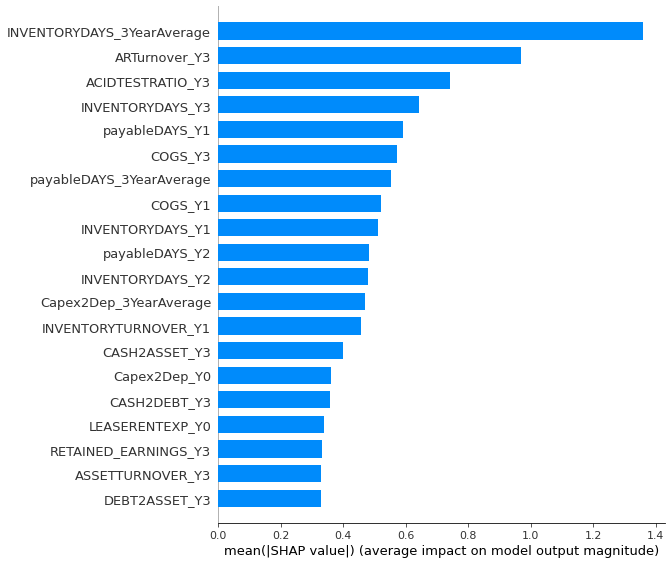

In [22]:
shap.summary_plot(k_shap_values, imputed_df_train.values, plot_type="bar",  feature_names = imputed_df_train.columns)
